## Plant Disease Detection

#### Importing Librarys

In [ ]:
# Standard Library Imports
import warnings

# External Library Imports
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import random
import plotly.express as px
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.layers import (Activation, BatchNormalization, Conv2D,
                                     Dense, Dropout, Flatten, MaxPooling2D)
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set seaborn style
sns.set_style('whitegrid')

# Filter Warnings
warnings.filterwarnings('ignore')

In [ ]:
!pip install kaggle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! mkdir ~/.kagglea

mkdir: cannot create directory ‘/root/.kagglea’: File exists


In [ ]:
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download abdallahalidev/plantvillage-dataset

100% 2.04G/2.04G [01:10<00:00, 32.3MB/s]
100% 2.04G/2.04G [01:10<00:00, 31.0MB/s]


In [ ]:
import zipfile

with zipfile.ZipFile('/content/plantvillage-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/plantvillage-dataset')


#### Load and Create DataFrame

In [ ]:
import os
import pandas as pd

# Define data directory
data = '/content/plantvillage-dataset/plantvillage dataset/color'

def create_dataframe(data_path):
    # List to store filepaths and labels
    filepaths = []
    labels = []

    # List all subfolders in the current data path
    folds = os.listdir(data_path)

    # Iterate through each subfolder
    for fold in folds:
        f_path = os.path.join(data_path, fold)
        imgs = os.listdir(f_path)

        # Iterate through images in the subfolder
        for img in imgs:
            img_path = os.path.join(f_path, img)

            # Append image path and corresponding label
            filepaths.append(img_path)
            labels.append(fold)

    # Create Pandas Series for filepaths and labels
    fseries = pd.Series(filepaths, name='Filepaths')
    lseries = pd.Series(labels, name='Labels')

    # Concatenate into a DataFrame and return
    return pd.concat([fseries, lseries], axis=1)

# Create DataFrames for train, test, and val
df = create_dataframe(data)

In [ ]:
df.head()

,Filepaths,Labels
0,/content/plantvillage-dataset/plantvillage dat...,Grape___healthy
1,/content/plantvillage-dataset/plantvillage dat...,Grape___healthy
2,/content/plantvillage-dataset/plantvillage dat...,Grape___healthy
3,/content/plantvillage-dataset/plantvillage dat...,Grape___healthy
4,/content/plantvillage-dataset/plantvillage dat...,Grape___healthy


In [ ]:
df.shape

(54305, 2)

In [ ]:
# Print the unique classes in the DataFrame
print("The classes:\n", np.unique(df['Labels']))


The classes:
 ['Apple___Apple_scab' 'Apple___Black_rot' 'Apple___Cedar_apple_rust'
 'Apple___healthy' 'Blueberry___healthy'
 'Cherry_(including_sour)___Powdery_mildew'
 'Cherry_(including_sour)___healthy'
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot'
 'Corn_(maize)___Common_rust_' 'Corn_(maize)___Northern_Leaf_Blight'
 'Corn_(maize)___healthy' 'Grape___Black_rot'
 'Grape___Esca_(Black_Measles)'
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)' 'Grape___healthy'
 'Orange___Haunglongbing_(Citrus_greening)' 'Peach___Bacterial_spot'
 'Peach___healthy' 'Pepper,_bell___Bacterial_spot'
 'Pepper,_bell___healthy' 'Potato___Early_blight' 'Potato___Late_blight'
 'Potato___healthy' 'Raspberry___healthy' 'Soybean___healthy'
 'Squash___Powdery_mildew' 'Strawberry___Leaf_scorch'
 'Strawberry___healthy' 'Tomato___Bacterial_spot' 'Tomato___Early_blight'
 'Tomato___Late_blight' 'Tomato___Leaf_Mold' 'Tomato___Septoria_leaf_spot'
 'Tomato___Spider_mites Two-spotted_spider_mite' 'Tomato___Target_Spot'


In [ ]:
# Count the number of images in each class
class_counts = df['Labels'].value_counts()
class_counts

Orange___Haunglongbing_(Citrus_greening)              5507
Tomato___Tomato_Yellow_Leaf_Curl_Virus                5357
Soybean___healthy                                     5090
Peach___Bacterial_spot                                2297
Tomato___Bacterial_spot                               2127
Tomato___Late_blight                                  1909
Squash___Powdery_mildew                               1835
Tomato___Septoria_leaf_spot                           1771
Tomato___Spider_mites Two-spotted_spider_mite         1676
Apple___healthy                                       1645
Tomato___healthy                                      1591
Blueberry___healthy                                   1502
Pepper,_bell___healthy                                1478
Tomato___Target_Spot                                  1404
Grape___Esca_(Black_Measles)                          1383
Corn_(maize)___Common_rust_                           1192
Grape___Black_rot                                     11

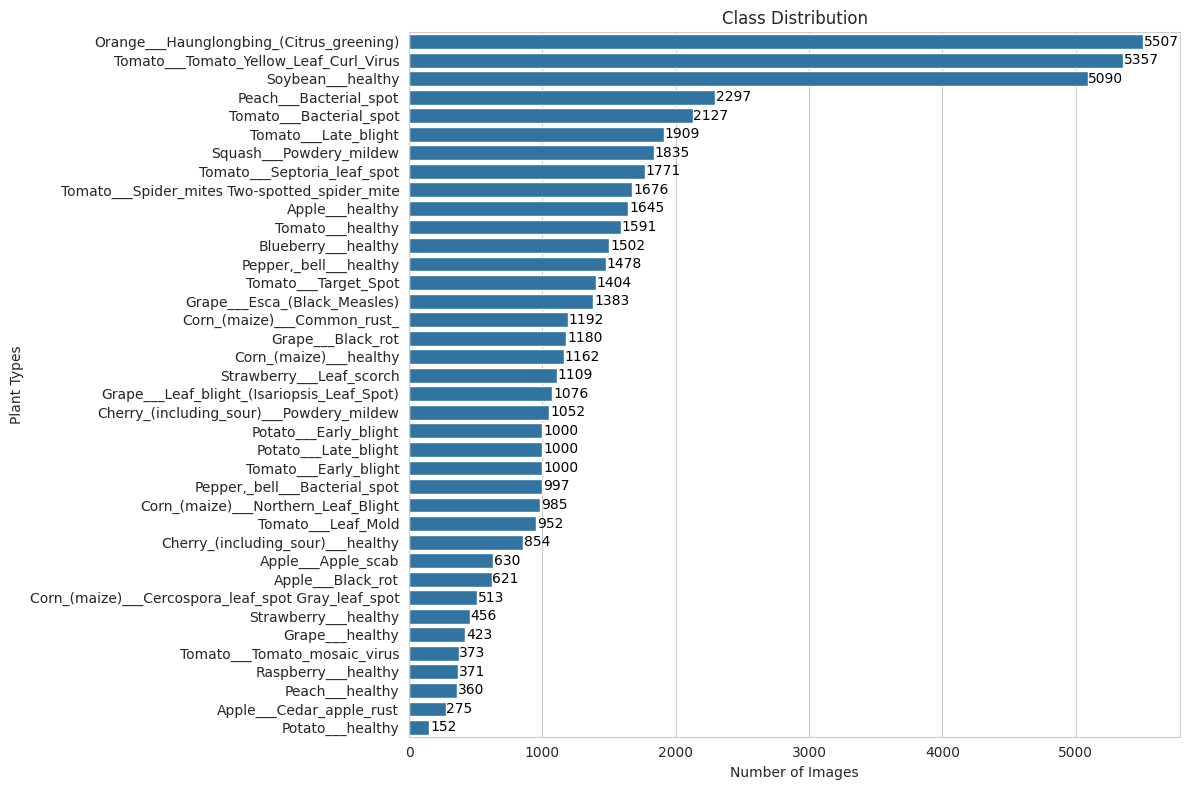

In [ ]:
# Visualize class distribution using a horizontal bar plot
plt.figure(figsize=(12, 8))
ax = sns.barplot(x=class_counts.values, y=class_counts.index, orient='h')
plt.title('Class Distribution')
plt.xlabel('Number of Images')
plt.ylabel('Plant Types')
plt.tight_layout()  # Adjust the layout to prevent overlapping labels

# Add data labels to each bar
for i, v in enumerate(class_counts.values):
    ax.text(v + 5, i, str(v), color='black', va='center')

plt.show()

#### Creation of Training/Testing set

In [ ]:
from sklearn.model_selection import train_test_split

# Splitting data into train and dummy sets
train_df, dummy_df = train_test_split(df, train_size=0.8, shuffle=True, random_state=42)

# Further splitting dummy set into validation and test sets
valid_df, test_df = train_test_split(dummy_df, train_size=0.5, shuffle=True, random_state=42)

#### Data Generators

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define image data generators for train, validation, and test
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create flow_from_dataframe generators for train, validation, and test
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepaths',
    y_col='Labels',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

valid_generator = valid_datagen.flow_from_dataframe(
    dataframe=valid_df,
    x_col='Filepaths',
    y_col='Labels',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepaths',
    y_col='Labels',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 43444 validated image filenames belonging to 38 classes.
Found 5430 validated image filenames belonging to 38 classes.
Found 5431 validated image filenames belonging to 38 classes.


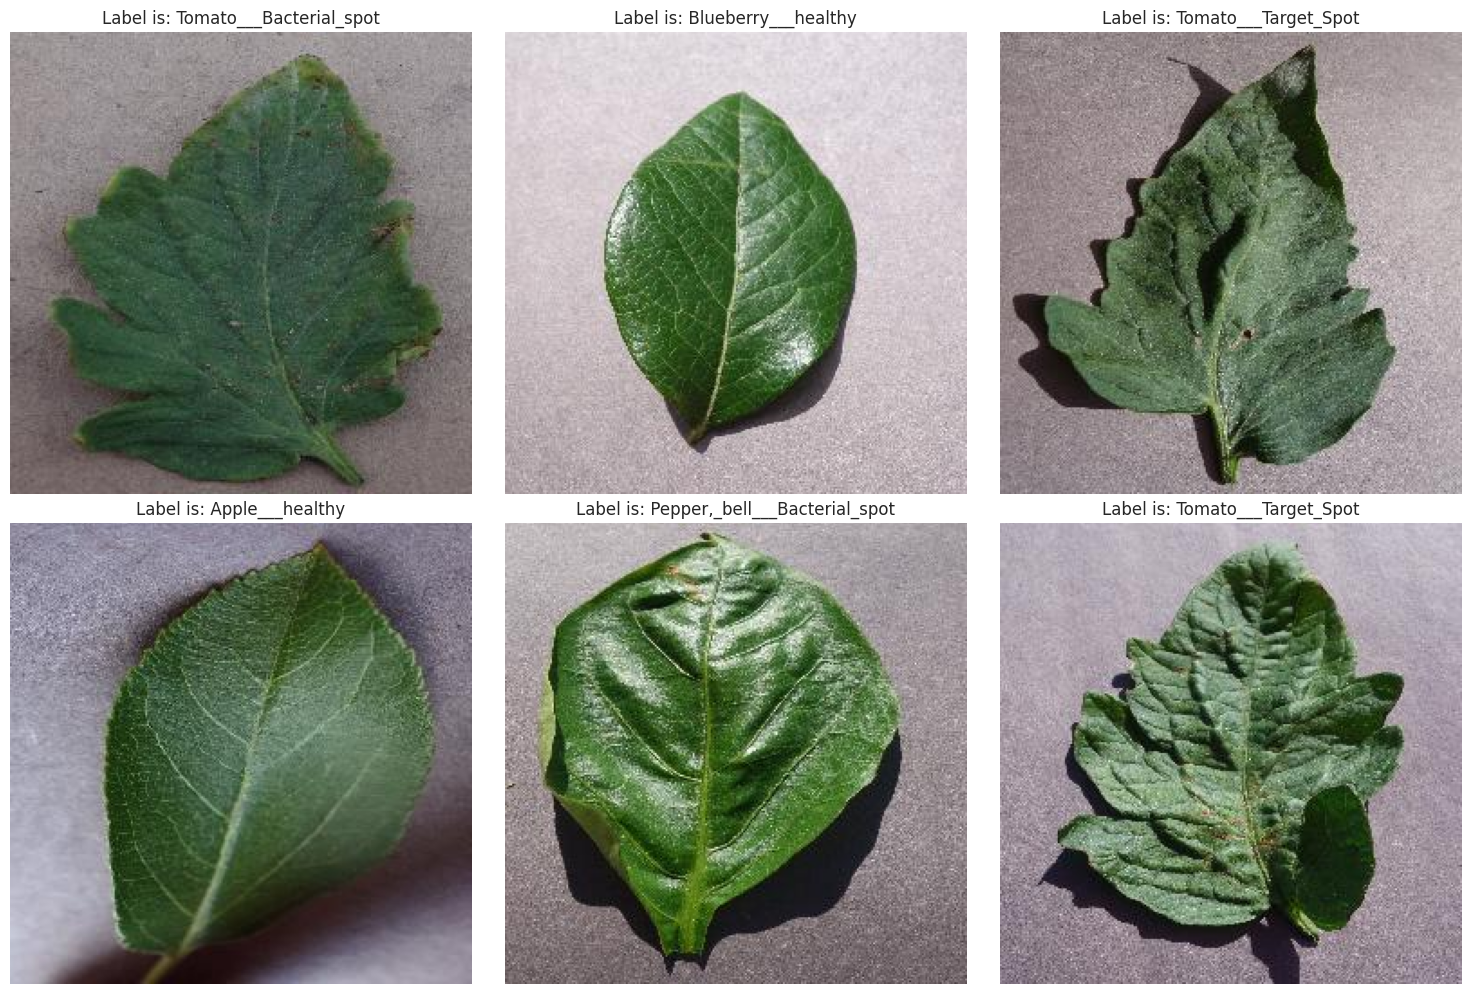

In [ ]:
# Function to plot images with their labels
def plot_samples(df, num_samples=6):
    plt.figure(figsize=(15, 10))
    for i in range(num_samples):
        # Randomly select an image
        rand_idx = random.randint(0, len(df) - 1)
        img_path = df.iloc[rand_idx]['Filepaths']
        label = df.iloc[rand_idx]['Labels']

        # Read and plot the image
        img = plt.imread(img_path)
        plt.subplot(2, 3, i+1)
        plt.imshow(img)
        plt.title(f'Label is: {label}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Call the function to plot 6 random samples
plot_samples(train_df)

####  Building and Training

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Dense, Dropout

# Define the base model
base_model = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3), pooling='max')

# Construct the model
model = Sequential([
    base_model,
    BatchNormalization(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(38, activation='softmax') # Modifierr   38
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adamax(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
trainmodel = model.fit(
    x=train_generator,
    validation_data=valid_generator,
    epochs=1,
    verbose=1,
    validation_steps=None,
    shuffle=False
)

 163/1358 [==>...........................] - ETA: 9:39:24 - loss: 1.2444 - accuracy: 0.6854

KeyboardInterrupt: 

#### Evaluating the model

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print("Test Accuracy:", test_accuracy)

#### displaying Training / Validatation Metrics

In [ ]:
# Extracting data from trainmodel
tr_acc = trainmodel.trainmodel['accuracy']
tr_loss = trainmodel.trainmodel['loss']
val_acc = trainmodel.trainmodel['val_accuracy']
val_loss = trainmodel.trainmodel['val_loss']

epochs = range(1, len(tr_acc) + 1)

# Plotting training and validation metrics
plt.figure(figsize=(20, 8))

# Plotting loss
plt.subplot(1, 2, 1)
plt.plot(epochs, tr_loss, 'r', label='Train Loss')
plt.plot(epochs, val_loss, 'g', label='Valid Loss')
plt.title('Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Plotting accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, tr_acc, 'r', label='Train Accuracy')
plt.plot(epochs, val_acc, 'g', label='Valid Accuracy')
plt.title('Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()